# Facebook Page Rank

Adjacency matrix. 

### Download fron SNAP

https://snap.stanford.edu/data/facebook-large-page-page-network.html

### Reference

* Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters, Mahoney
  https://arxiv.org/pdf/0810.1355

### Outputs

* `snap_facebook_adj.npy`: adjacency matrix
* `snap_facebook_eig.npy`: eigenvalues of adjacency matrix
* `snap_facebook_eig.pdf`: ESD of adjacency matrix

In [1]:
import numpy as np
import numpy
import scipy.sparse
import scipy.sparse as sp
import matplotlib.pyplot as plt
from os.path import join
import texplot

In [2]:
# Load data
edges = np.loadtxt('./data-facebook/musae_facebook_edges.csv',
                   delimiter=',', skiprows=1, dtype=int)
print(edges.shape)

(171002, 2)


In [3]:
# Compute Adjacency and save

# Find number of nodes (node IDs are 0-indexed)
n_nodes = edges.max() + 1

# Build sparse adjacency matrix
A = scipy.sparse.coo_matrix(
    (np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    shape=(n_nodes, n_nodes)
)

# Since the graph is undirected, symmetrize it
A = A + A.T

# Make sure all nonzero entries are 1
A.data = np.ones_like(A.data)

A = A.toarray()
n = A.shape[0]
print(A.shape)
print(sp.issparse(A))

(22470, 22470)
False


In [4]:
# choose p so that each leaf gets ≥1 new neighbor w.h.p.:
n = A.shape[0]
p = np.log(n) / n  
rng = np.random.default_rng(42)
R = (rng.random((n, n)) < p).astype(int)
R = np.triu(R, 1)
R = R + R.T
A = np.minimum(A + R, 1)   # still 0/1

In [5]:
# Center
# n = A.shape[0]
# p = A.sum() / (n*(n-1))      # empirical edge‐probability
# A_c = A - p * np.ones((n, n))

# Laplacian
d = A.sum(axis=1)  # degree vector
D = np.diag(d)
L = D - A

# Symmetric normalized Laplacian:
# L_sym = D^{-1/2} L D^{-1/2}  =  I – D^{-1/2} A D^{-1/2}
# eigenvalues lie in [0,2]
with np.errstate(divide='ignore'):
    d_sqrt_inv = 1.0/np.sqrt(d)
d_sqrt_inv[np.isinf(d_sqrt_inv)] = 0.0
D_sqrt_inv = np.diag(d_sqrt_inv)
I = np.eye(n)
L_sym = I - D_sqrt_inv @ A @ D_sqrt_inv

# Modularity matrix           
m = d.sum()/2
Dd = np.outer(d, d) / (2*m)
B = A - Dd

# Bethe-Hessian
# For the choice of "r", see "Spectral Clustering of Graphs with the Bethe Hessian"
I = np.eye(A.shape[0])
r = np.sqrt(d.mean())
H = (r**2 - 1)*I - r*A + D

# Save
dir_ = './data-tmp'
np.save(join(dir_, 'snap_facebook_alt_adj.npy'), A)
np.save(join(dir_, 'snap_facebook_alt_lap.npy'), L)
np.save(join(dir_, 'snap_facebook_alt_lap_sym.npy'), L_sym)
np.save(join(dir_, 'snap_facebook_alt_mod.npy'), B)
np.save(join(dir_, 'snap_facebook_alt_hes.npy'), H)

In [6]:
# Compute eigenvalues of adjacency
eig_adj = np.linalg.eigvalsh(A, UPLO='U')
np.save(join(dir_, 'snap_facebook_alt_adj_eig.npy'), eig_adj)

# Compute eigenvalues of Laplacian
eig_lap = np.linalg.eigvalsh(L, UPLO='U')
np.save(join(dir_, 'snap_facebook_alt_lap_eig.npy'), eig_lap)

# Compute eigenvalues of symmetric Laplacian
eig_lap_sym = np.linalg.eigvalsh(L_sym, UPLO='U')
np.save(join(dir_, 'snap_facebook_alt_lap_sym_eig.npy'), eig_lap_sym)

# Compute eigenvalues of Modularity
eig_mod = np.linalg.eigvalsh(B, UPLO='U')
np.save(join(dir_, 'snap_facebook_alt_mod_eig.npy'), eig_mod)

# Compute eigenvalues of Bethe-Hessian
eig_hes = np.linalg.eigvalsh(H, UPLO='U')
np.save(join(dir_, 'snap_facebook_alt_hes_eig.npy'), eig_hes)

# Plot Density

In [7]:
# =================
# hist in log scale
# =================

def hist_in_log_scale(eig, nbins):
    """
    Histogram of a variable itself, but in log scale.
    """
    
    u = np.log10(eig[eig>0])
    bins_u = np.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = np.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = 10.0**u_mid
    density = counts / lambda_
    return density, lambda_

Plot saved to "/data/sameli/facebook/facebook/./plot-tmp/snap_facebook_alt_eig.pdf".


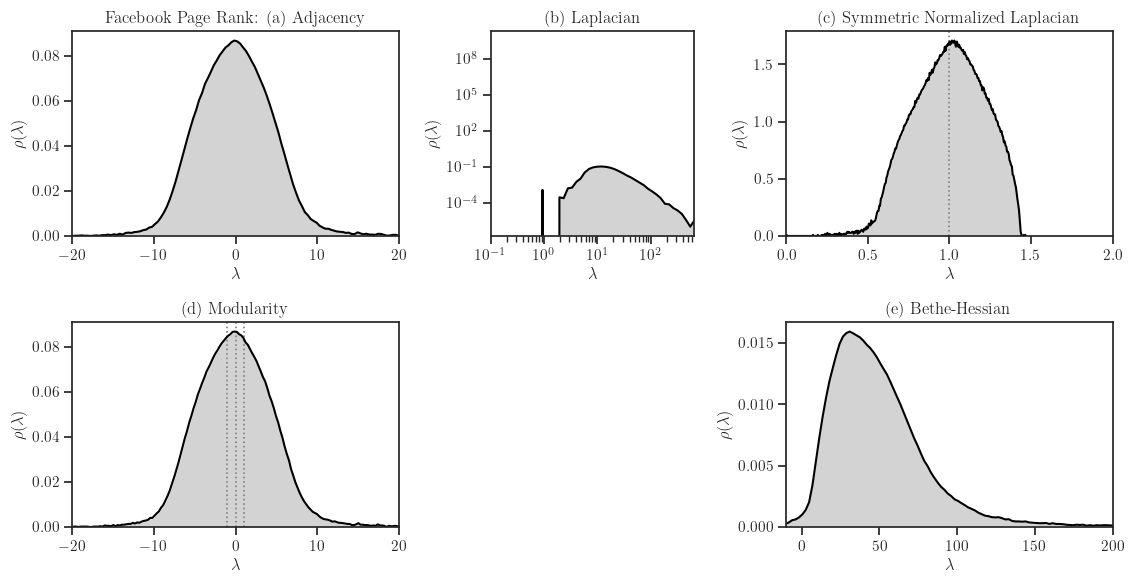

In [9]:
# Plot eigenvalues
eig_adj = np.load(join(dir_, 'snap_facebook_alt_adj_eig.npy'))
eig_lap = np.load(join(dir_, 'snap_facebook_alt_lap_eig.npy'))
eig_lap_sym = np.load(join(dir_, 'snap_facebook_alt_lap_sym_eig.npy'))
eig_mod = np.load(join(dir_, 'snap_facebook_alt_mod_eig.npy'))
eig_hes = np.load(join(dir_, 'snap_facebook_alt_hes_eig.npy'))

# # Clip
# eig_adj = eig_adj[np.abs(eig_adj) < 20]
# eig_mod = eig_mod[np.abs(eig_mod) < 10]
# eig_hes = eig_hes[np.logical_and(eig_hes > -20, eig_hes < 80)]

# # Remove spikes
# tol = 1e-3
# adj_spikes = np.arange(-1, 2)
# lap_sym_spikes = [1]
# for spike in adj_spikes:
#     mask = ~np.isclose(eig_lap_sym, spike, atol=tol)
#     eig_lap_sym = eig_lap_sym[mask]

# # Remove spikes
# tol = 1e-3
# lap_sym_spikes = [1]
# for spike in lap_sym_spikes:
#     mask = ~np.isclose(eig_lap_sym, spike, atol=tol)
#     eig_lap_sym = eig_lap_sym[mask]

# # Remove spikes
# tol = 1e-3
# mod_spikes = [-1, 0]
# for spike in mod_spikes:
#     mask = ~np.isclose(eig_mod, spike, atol=tol)
#     eig_mod = eig_mod[mask]

h_adj, bins_adj = np.histogram(eig_adj, 400, density=True)
h_lap, bins_lap_c = hist_in_log_scale(eig_lap, 200)
h_lap_sym, bins_lap_sym = np.histogram(eig_lap_sym, 300, density=True)
h_mod, bins_mod = np.histogram(eig_mod, 500, density=True)
h_hes, bins_hes = np.histogram(eig_hes, 500, density=True)

bins_adj_c = 0.5 * (bins_adj[1:] + bins_adj[:-1])
# bins_lap_c = 0.5 * (bins_lap[1:] + bins_lap[:-1])
bins_lap_sym_c = 0.5 * (bins_lap_sym[1:] + bins_lap_sym[:-1])
bins_mod_c = 0.5 * (bins_mod[1:] + bins_mod[:-1])
bins_hes_c = 0.5 * (bins_hes[1:] + bins_hes[:-1])

with texplot.theme(use_latex=True):
    
    fig = plt.figure(figsize=(11.5, 6))
    gs  = fig.add_gridspec(2, 3, width_ratios=[1.6, 1, 1.6])

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(bins_adj_c, h_adj, color='black')
    ax0.fill_between(bins_adj_c, h_adj, facecolor='lightgray', zorder=-2)

    #  Spike lines
    # for spike in adj_spikes:
    #     ax0.axvline(spike, linestyle=':', linewidth=1.2, color='gray', zorder=-1)

    # ax0.set_yscale('log')
    ax0.set_xlabel(r'$\lambda$')
    ax0.set_ylabel(r'$\rho(\lambda)$')
    ax0.set_title('Facebook Page Rank: (a) Adjacency')
    ax0.set_ylim(bottom=0)
    # ax0.set_xlim([-10, 10])
    ax0.set_xlim([-20, 20])

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(bins_lap_c, h_lap, color='black')
    ax1.fill_between(bins_lap_c, h_lap, facecolor='lightgray', zorder=-2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel(r'$\rho(\lambda)$')
    ax1.set_title('(b) Laplacian')
    ax1.set_ylim(bottom=0)
    ax1.set_xlim([1e-1, bins_lap_c[-1]])

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(bins_lap_sym_c, h_lap_sym, color='black')
    ax2.fill_between(bins_lap_sym_c, h_lap_sym, facecolor='lightgray', zorder=-2)
    ax2.axvline(1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    # ax2.set_yscale('log')
    ax2.set_xlabel(r'$\lambda$')
    ax2.set_ylabel(r'$\rho(\lambda)$')
    ax2.set_title('(c) Symmetric Normalized Laplacian')
    ax2.set_xlim([0, 2])
    ax2.set_ylim(bottom=0)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(bins_mod_c, h_mod, color='black')
    ax3.fill_between(bins_mod_c, h_mod, facecolor='lightgray', zorder=-2)
    ax3.axvline(-1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    ax3.axvline(0, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    ax3.axvline(1, linestyle=':', linewidth=1.2, color='gray', zorder=-1)
    # ax3.set_yscale('log')
    ax3.set_xlabel(r'$\lambda$')
    ax3.set_ylabel(r'$\rho(\lambda)$')
    ax3.set_title('(d) Modularity')
    # ax3.set_xlim([-10, 10])
    ax3.set_xlim([-20, 20])
    ax3.set_ylim(bottom=0)

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.plot(bins_hes_c, h_hes, color='black')
    ax4.fill_between(bins_hes_c, h_hes, facecolor='lightgray', zorder=-2)
    # ax4.set_yscale('log')
    ax4.set_xlabel(r'$\lambda$')
    ax4.set_ylabel(r'$\rho(\lambda)$')
    ax4.set_title('(e) Bethe-Hessian')
    ax4.set_xlim([-10, 200])
    ax4.set_ylim(bottom=0)

    plt.tight_layout()
    texplot.show_or_save_plot(plt, default_filename='./plot-tmp/snap_facebook_alt_eig.pdf',
                              transparent_background=True, dpi=200,
                              show_and_save=True, verbose=True)

# Compute Eigenvalues (Symmetric Laplacian)

In [10]:
dir_ = './data-tmp'
L_sym = np.load(join(dir_, 'snap_facebook_alt_lap_sym.npy'))

In [12]:
import scipy
subsizes = list(2**numpy.arange(11, 15)) + [L_sym.shape[0]]
subsizes = [int(subsize) for subsize in subsizes]
print(subsizes)

eigs = []

for i in range(len(subsizes)):
    n = subsizes[i]
    print(f'processing: {i}', flush=True)
    eig = scipy.linalg.eigvalsh(L_sym[:n, :n])
    eigs.append(numpy.copy(eig))

print('Done.')

[2048, 4096, 8192, 16384, 22470]
processing: 0
processing: 1
processing: 2
processing: 3
processing: 4
Done.


In [16]:
res = {
    'subsizes': subsizes,
    'eigs': eigs,
}

dir_ = './data-tmp'
np.save(join(dir_, 'snap_facebook_alt_lap_sym_all_eigs.npy'), res)

# FreeForm (START HERE)

In [10]:
import numpy as np
import numpy
import scipy.sparse
import scipy.sparse as sp
import matplotlib.pyplot as plt
from os.path import join
import texplot

dir_ = './data-tmp'
data = np.load(join(dir_, 'snap_facebook_alt_lap_sym_all_eigs.npy'),
              allow_pickle=True).item()
start = 1
subsizes = data['subsizes'][start:]
eigs = data['eigs'][start:]
print('Original:')
print(subsizes)

# Remove the spike of only the first eig
tol = 5e-4
spikes = [1.0]
for spike in spikes:
    mask = ~np.isclose(eigs[0], spike, atol=tol)
    eigs[0] = eigs[0][mask]

subsizes[0] = eigs[0].size
print('\nFiltered: ')
print(subsizes)

Original:
[4096, 8192, 16384, 22470]

Filtered: 
[3800, 8192, 16384, 22470]


In [11]:
# ----------------------
# Estimatre pdf from eig
# ----------------------

import freealg as fa

pdfs = []
x = numpy.linspace(0, 2, 1000)
for i in range(len(subsizes)):
    eig = eigs[i]
    lam_m = numpy.min(eig)
    lam_p = numpy.max(eig)
    pdf = fa.kde(eig, x, lam_m=lam_m, lam_p=lam_p, h=0.005, kernel='beta')
    pdfs.append(numpy.copy(pdf))

print('Done.')

Done.


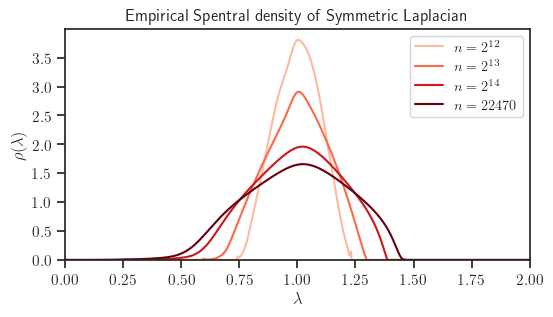

In [13]:
num_plots = len(pdfs)
cmap = plt.get_cmap('Reds')
colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]

with texplot.theme(use_latex=True):

    fig, ax = plt.subplots(figsize=(6, 3))
    
    for i in range(0, len(pdfs)):
        if i != len(pdfs) - 1:
            p = int(numpy.log2(subsizes[i]) + 0.5)
            label = rf'$n=2^{{{p}}}$'
        else:
            label = rf'$n={{{subsizes[i]}}}$'
        ax.plot(x, pdfs[i], color=colors[i], label=label)
        ax.set_xlim([0, 2])
        ax.set_ylim(bottom=0)
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r'$\rho(\lambda)$')
        ax.set_title('Empirical Spentral density of Symmetric Laplacian')
        ax.legend(fontsize='small')

save_filename = './plot-tmp/snap_facebook_alt_lap_sym_all_eigs.pdf'
texplot.show_or_save_plot(plt, default_filename=save_filename,
                                  transparent_background=True, dpi=200,
                                  show_and_save=False, verbose=True)

num nans: 0
size: 3800
min eig: 0.7411
max eig: 1.2315


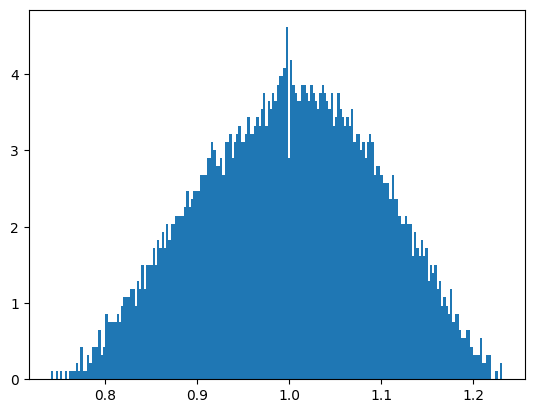

In [17]:
# ------------------------------------
# Selecting One of eigs as Initial eig
# ------------------------------------

eig_init = eigs[0]
nan_mask = numpy.isnan(eig_init)
print(f'num nans: {nan_mask.sum()}')
print(f'size: {eig_init.size}')

min_eig = numpy.min(eig_init)
max_eig = numpy.max(eig_init)

print(f'min eig: {min_eig:>0.4f}')
print(f'max eig: {max_eig:>0.4f}')

h = plt.hist(eig_init, 200, density=True)
plt.show()

In [16]:
# ---------------
# FreeForm Object
# ---------------

import numpy
import freealg as f
eps = -0.05  # use minus
ff = fa.FreeForm(eig_init, support=(min_eig, max_eig + eps), delta=1e-6,
                 dtype='complex128', p=0.00001)

print(f'min lam: {ff.lam_m:>0.3f}')
print(f'max lam: {ff.lam_p:>0.3f}')

min lam: 0.741
max lam: 1.181


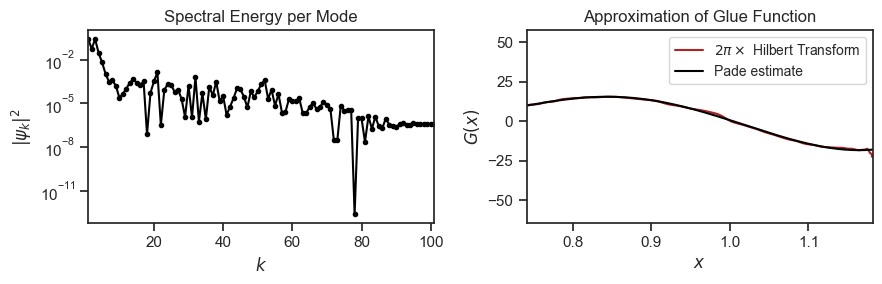

{'c': np.float64(-330549.2712925738), 'D': np.float64(47435.72387123405), 'poles': array([-0.91929649, -1.13891548, -1.29347862]), 'resid': array([  6151148.70245158, -23643179.02624374,  18650643.6935845 ]), 'outer_iters': 39}
Plot saved to "/home/sia/work/scripts/free/facebook/./plot-tmp/facebook-fit.pdf".


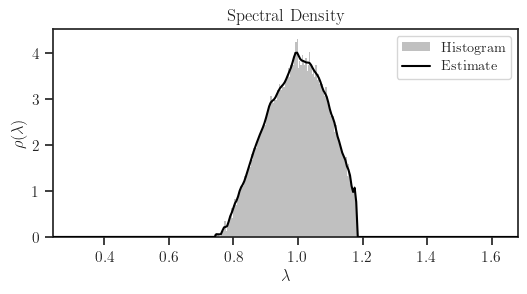

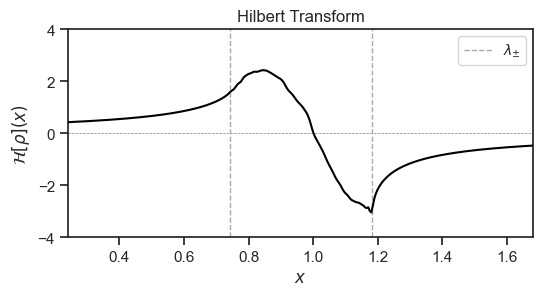

In [61]:
# ---
# Fit
# ---

psi = ff.fit(method='jacobi', K=100, alpha=0, beta=0, n_quad=60, reg=0,
             projection='beta', kernel_bw=0.00001, damp='jackson', force=True,
             continuation='pade', pade_p=4, pade_q=3, odd_side='left',
             pade_reg=0, optimizer='de', plot=True)

print(ff._pade_sol)

x = numpy.linspace(ff.lam_m-0.5, ff.lam_p+0.5, 300)
rho = ff.density(x, plot=True, latex=True, save='./plot-tmp/facebook-fit.pdf')
hilb = ff.hilbert(x, rho, plot=True)

Plot saved to "/home/sia/work/scripts/free/facebook/./plot-tmp/facebook_stieltjes.pdf".


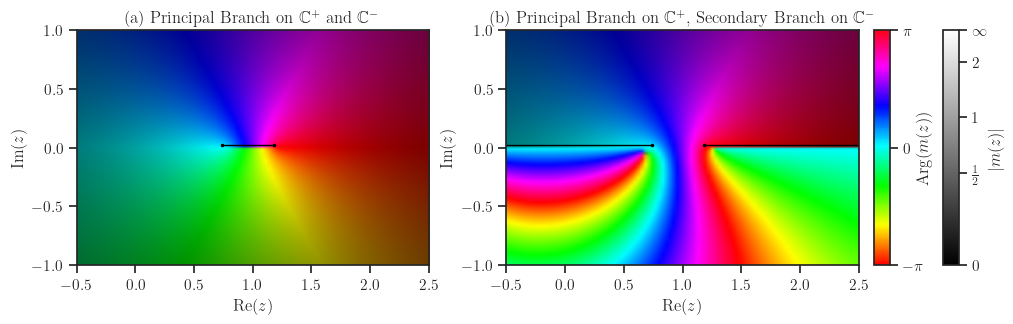

In [62]:
c = 1
d = 1
x = numpy.linspace(-0.5, 2.5, 100)
y = numpy.linspace(-1, 1, 100)
m1, m2 = ff.stieltjes(x, y, plot=True, latex=True, save='./plot-tmp/facebook_stieltjes.pdf')

In [21]:
# ------------
# Generate PDF
# ------------

import time

x_pred = numpy.linspace(0, 2, 1000)
pdfs = []

for i in range(0, len(subsizes)):
    
    print(f'{i}, ', end='')

    # Original data (loaded from file)
    lam_m = numpy.min(eigs[i])
    lam_p = numpy.max(eigs[i])
    pdf = fa.kde(eigs[i], x_pred, lam_m=lam_m, lam_p=lam_p, h=0.01, kernel='beta')
    pdfs.append(numpy.copy(pdf))

print('Done.')

0, 1, 2, 3, Done.


In [63]:
# ----------
# Decompress
# ----------

rhos_pred = []
eigs_pred =[]
pdfs_pred = []
x = numpy.linspace(0, 2, 1000)

for subsize in subsizes:

    print(f'subsize: {subsize:5d} | ', end='')

    init_wall_time = time.time()
    init_proc_time = time.process_time()
    
    rho_pred, _ = ff.decompress(subsize, x, method='newton', max_iter=500,
                                step_size=0.1, tolerance=1e-4)

    wall_time = time.time() - init_wall_time
    proc_time = time.process_time() - init_proc_time
    
    print(f'wall_time: {wall_time:>5.2f}, proc_time: {proc_time:>5.2f} | regenerate PDF ...',
          end='')

    eig_pred = numpy.sort(fa.sample(x, rho_pred, subsize, seed=0))
    rhos_pred.append(numpy.copy(rho_pred))
    eigs_pred.append(numpy.copy(eig_pred))

    # Predicted data (using free decompression)
    lam_m = numpy.min(eig_pred)
    lam_p = numpy.max(eig_pred)
    pdf_pred = fa.kde(eig_pred, x_pred, lam_m=lam_m, lam_p=lam_p, h=0.01, kernel='beta')
    pdfs_pred.append(numpy.copy(pdf_pred))

    print(' done.')

subsize:  3800 | wall_time:  0.02, proc_time:  0.02 | regenerate PDF ... Done.
subsize:  8192 | wall_time:  1.69, proc_time:  1.69 | regenerate PDF ... Done.
subsize: 16384 | wall_time:  1.26, proc_time:  1.26 | regenerate PDF ... Done.
subsize: 22470 | wall_time:  1.25, proc_time:  1.25 | regenerate PDF ... Done.


Plot saved to "/home/sia/work/scripts/free/facebook/./plot-tmp/snap_facebook_all_eigs_pred.pdf".


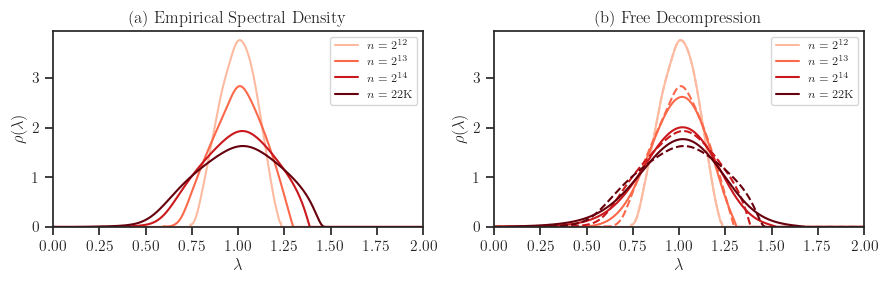

In [64]:
# ----
# Plot
# ----

num_plots = len(pdfs_pred)
cmap = plt.get_cmap('Reds')
colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]

rc={'font.family': 'serif'}
with texplot.theme(rc=rc, use_latex=True):

    fig, ax = plt.subplots(figsize=(9, 3), ncols=2)
    
    for i in range(len(pdfs)):
        if i != len(pdfs) - 1:
            p = int(numpy.log2(subsizes[i]) + 0.5)
            label = rf'$n=2^{{{p}}}$'
        else:
            label = rf'$n={{{subsizes[i]//1000}}}$K'

        ax[0].plot(x_pred, pdfs[i], '-', color=colors[i], label=label)

        if i == 0:
            ax[1].plot(x_pred, pdfs[i], '-', color=colors[i], label=label)
        else:
            ax[1].plot(x_pred, pdfs_pred[i], color=colors[i], label=label)
        ax[1].plot(x_pred, pdfs[i], '--', color=colors[i])

    ax[0].set_xlim([0, 2])
    ax[0].set_ylim(bottom=0)
    ax[0].set_xlabel(r'$\lambda$')
    ax[0].set_ylabel(r'$\rho(\lambda)$')
    ax[0].set_title('(a) Empirical Spectral Density')
    ax[0].legend(fontsize='x-small')
        
    ax[1].set_xlim([0, 2])
    ax[1].set_ylim(bottom=0)
    ax[1].set_xlabel(r'$\lambda$')
    ax[1].set_ylabel(r'$\rho(\lambda)$')
    ax[1].set_title('(b) Free Decompression')
    ax[1].legend(fontsize='x-small')
    
    plt.tight_layout()

    save_filename = './plot-tmp/snap_facebook_all_eigs_pred.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                                      transparent_background=True, dpi=200,
                                      show_and_save=True, verbose=True)

In [65]:
plot_data = {
    'subsizes': subsizes,
    'x_pred': x_pred,
    'pdfs': pdfs,
    'pdfs_pred': pdfs_pred,
}

numpy.save('./plot_data_snap_facebook.npy', plot_data)